<a href="https://colab.research.google.com/github/MaCoZu/NLP/blob/main/02_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers

In [4]:
datasets, info = tfds.load(
    "imdb_reviews/plain_text",
    split=["train", "test[:50%]", "test[50%:]"], # train, validate, test
    as_supervised=True,
    with_info=True
)

dataset_train_original = datasets[0] #
dataset_validate_original = datasets[1]
dataset_test_original = datasets[2]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNACG9B/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNACG9B/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNACG9B/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
for review, label in dataset_train_original.take(16):
  print(review.numpy().decode("utf-8"))
  print(label.numpy())
  print("-"*80)

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0
--------------------------------------------------------------------------------
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this

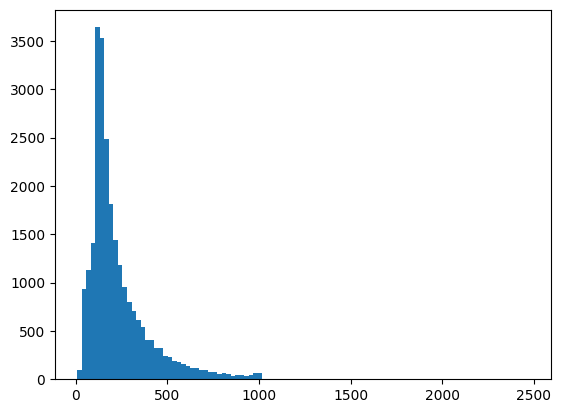

In [6]:
lenghts = []
for x, _ in dataset_train_original:
  x = x.numpy().decode("utf-8")
  lenghts += [len(x.split())]

plt.hist(lenghts, bins=100)
plt.show()

In [7]:
print('Min:', np.min(lenghts))
print('Mean:', np.mean(lenghts))
print('Max:', np.max(lenghts))
print('Std:', round(np.std(lenghts), 2))

Min: 10
Mean: 233.7872
Max: 2470
Std: 173.73


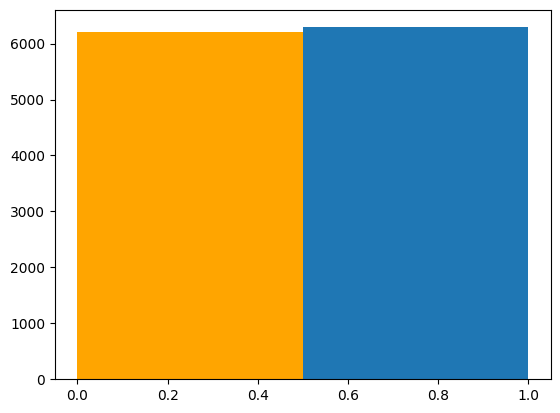

In [8]:
labels = []

for _, label in dataset_test_original:
  label = label.numpy()
  labels += [label]

_, _, patches = plt.hist(labels, bins=2)
patches[0].set_facecolor("orange")
plt.show()

# Bag of words encoding

In [9]:
vocabulary_size = 20_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='multi_hot',
    )

encoder.adapt(dataset_train_original.map(lambda text, label: text).batch(2048))

In [10]:
vocabulary = encoder.get_vocabulary()
print(vocabulary[:40])

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'her']


In [11]:
text = "make AI open again."

# representation of the text as a array of ones and zeros
text_encoded = encoder(text).numpy()
text_encoded = [str(int(x)) for x in text_encoded]
text_encoded = "".join(text_encoded)
print(text_encoded)

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000

# Dataset pipelines

In [12]:
dataset_train = dataset_train_original.cache().shuffle(25_000).batch(128)
dataset_validate = dataset_validate_original.cache().batch(128)
dataset_test = dataset_test_original.batch(128)

# ANN

In [13]:
model = models.Sequential()
model.add(encoder)
# model.add(layers.Dense(4, activation='relu'))
# model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    dataset_train,
    epochs=12,
    validation_data=dataset_validate
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 20000)            0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 20,001
Trainable params: 20,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
196/196 [==============================] - 4s 15ms/step - loss: 0.5194 - accuracy: 0.8217 - val_loss: 0.4349 - val_accuracy: 0.8601
Epoch 2/12
196/196 [==============================] - 3s 14ms/step - loss: 0.3609 - accuracy: 0.8910 - val_loss: 0.3655 - val_accuracy: 0.8778
Epoch 3/12
196/196 [==============================] - 3s 14ms/step - loss: 0.2984 - accuracy: 0.

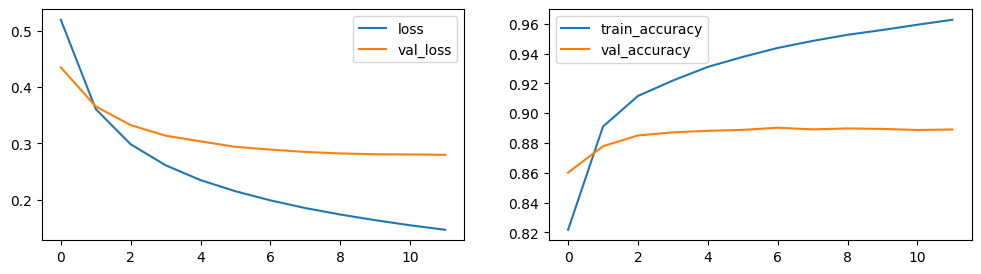

In [14]:
def render_history(history):
    assert isinstance(history, dict), f"Expected dict, but got {type(history)}"

    # Set the width and height of the figure
    plt.figure(figsize=(12, 3))

    ax1 = plt.subplot(121)
    ax1.plot(history["loss"], label="loss")
    ax1.plot(history["val_loss"], label='val_loss')
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.plot(history["accuracy"], label='train_accuracy')
    ax2.plot(history["val_accuracy"], label='val_accuracy')
    ax2.legend()
    plt.show()

render_history(history.history)

In [15]:
text = 'Wonderful movie, with lots of blood and swearing. A dark and dirty atmosphere made my heart jump higher in anticipation.'
model.predict([text])[0][0]

1/1 [==============================] - 0s 107ms/step


0.8325967

In [16]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=4766ee7608042d931680e1bb61cd097b8630f8378f3f75affd58d72a90e59f06
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [22]:
# Step 1: Log in to Weights & Biases
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: ERROR API key must be 40 characters long, yours was 1121
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [25]:
import wandb
from tensorflow import keras
from tensorflow.keras import layers


# Step 2: Initialize Weights & Biases run
wandb.init(project="imdb_classifier", config={
    "epochs": 12,
    "optimizer": "adam",
    "loss_function": "binary_crossentropy",
    "metrics": ["accuracy"]
})

# Step 3: Log model configuration
config = wandb.config

model.compile(
    optimizer=config.optimizer,
    loss=config.loss_function,
    metrics=config.metrics
)


# Training loop
for epoch in range(config.epochs):
    # Training code
    train_loss, train_accuracy = model.fit(
      dataset_train,
      validation_data=dataset_validate
      )

    # Validation code
    val_loss, val_accuracy = model.evaluate(dataset_validate)

    # Log metrics to Weights & Biases
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    })

# Finish the Weights & Biases run
wandb.finish()


196/196 [==============================] - 4s 16ms/step - loss: 0.0787 - accuracy: 0.9855 - val_loss: 0.3038 - val_accuracy: 0.8806


TypeError: ignored